### PuLP

Objective Value: 105.0
B_0_0 = 0.0
B_0_1 = 6.0
B_0_2 = 14.0
B_0_3 = 23.0
B_1_0 = 6.0
B_1_1 = 16.0
B_1_2 = 29.0
B_1_3 = 46.0
B_2_0 = 16.0
B_2_1 = 28.0
B_2_2 = 42.0
B_2_3 = 63.0
B_3_0 = 28.0
B_3_1 = 43.0
B_3_2 = 61.0
B_3_3 = 81.0
Z_0_0 = 0.0
Z_0_1 = 0.0
Z_0_2 = 1.0
Z_0_3 = 0.0
Z_1_0 = 0.0
Z_1_1 = 0.0
Z_1_2 = 0.0
Z_1_3 = 1.0
Z_2_0 = 0.0
Z_2_1 = 1.0
Z_2_2 = 0.0
Z_2_3 = 0.0
Z_3_0 = 1.0
Z_3_1 = 0.0
Z_3_2 = 0.0
Z_3_3 = 0.0
Objective Value: 105.0


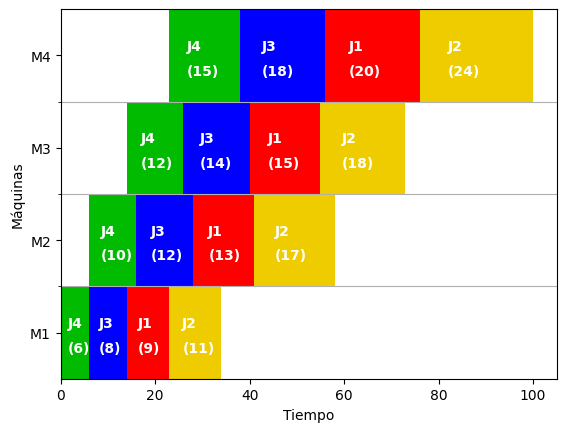

In [1]:
import pulp as lp
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
            [11, 17, 18, 24],
            [8, 12, 14, 18],
            [6, 10, 12, 15]])
T = T.transpose()

# Create the LP problem
model = lp.LpProblem("The_Wilson_Model", lp.LpMinimize)

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
B = lp.LpVariable.dicts("B", (range(N), range(M)), lowBound=0, cat='Integer')

# Define the objective function
model += B[N-1][M-1] + lp.lpSum(T[N-1][i] * Z[i][M-1] for i in range(N))


# Define the constraints
#(6)
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
#(7)
for j in range(N):
    model += lp.lpSum(Z[j][i] for j in range(N)) == 1

#(8)
for j in range(N-1):
    model += B[0][j] + lp.lpSum(T[0][i] * Z[i][j] for i in range(N)) == B[0][j+1]

#(9)
model += B[0][0] == 0

#(10)
for r in range(M-1):
    model += (B[r][0] + lp.lpSum(T[r][i] * Z[i][0] for i in range(N)) == B[r+1][0])

#(11)
for r in range(M-1):
    for j in range(1,N):
        model += (B[r][j] + lp.lpSum(T[r][i] * Z[i][j] for i in range(N)) <= B[r+1][j])
        
#(12)
for r in range(1,M):
    for j in range(N-1):
        model += (B[r][j] + lp.lpSum(T[r][i] * Z[i][j] for i in range(N)) <= B[r][j+1])

# Solve the LP problem
solution = model.solve()

# Print the optimal solution
print("Objective Value:", lp.value(model.objective))

for v in model.variables():
    print(v.name, "=", v.varValue)
print("Objective Value:", model.objective.value())

# Carta Gannt
import matplotlib.pyplot as plt

T = T.transpose()
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = lp.value(model.objective)
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

for i in range(M):
    inicio = lp.value(B[0][i])
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')
        inicio += duracion_tarea

### CPLEX

In [1]:
from docplex.mp.model import Model
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

# Create the model
model = Model(name="The_Wilson_Model")

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = {(i, j): model.binary_var(name=f"Z_{i}_{j}") for i in range(N) for j in range(N)}
B = {(i, j): model.integer_var(lb=0, name=f"B_{i}_{j}") for i in range(N) for j in range(M)}

# Define the objective function
model.minimize(B[N-1, M-1] + model.sum(T[N-1, i] * Z[i, M-1] for i in range(N)))

# Define the constraints
#(6)
for i in range(N):
    model.add_constraint(model.sum(Z[i, j] for j in range(N)) == 1)

#(7)
for j in range(N):
    model.add_constraint(model.sum(Z[i, j] for i in range(N)) == 1)

#(8)
for j in range(N-1):
    model.add_constraint(B[0, j] + model.sum(T[0, i] * Z[i, j] for i in range(N)) == B[0, j+1])

#Restriccion (9) no afecta FO

#(10)
for r in range(M-1):
    model.add_constraint(B[r, 0] + model.sum(T[r, i] * Z[i, 0] for i in range(N)) == B[r+1, 0])

#(11)
for r in range(M-1):
    for j in range(1, N):
        model.add_constraint(B[r, j] + model.sum(T[r, i] * Z[i, j] for i in range(N)) <= B[r+1, j])

#(12)
for r in range(1, M):
    for j in range(N-1):
        model.add_constraint(B[r, j] + model.sum(T[r, i] * Z[i, j] for i in range(N)) <= B[r, j+1])

# Solve the model
model.solve()

# Print the optimal solution
print("Objective Value:", model.objective_value)

for v in model.iter_variables():
    print(v.to_string(), "=", v.solution_value)

Objective Value: 105.0
Z_0_0 = 0
Z_0_1 = 0
Z_0_2 = 1.0
Z_0_3 = 0
Z_1_0 = 0
Z_1_1 = 0
Z_1_2 = 0
Z_1_3 = 1.0
Z_2_0 = 0
Z_2_1 = 1.0
Z_2_2 = 0
Z_2_3 = 0
Z_3_0 = 1.0
Z_3_1 = 0
Z_3_2 = 0
Z_3_3 = 0
B_0_0 = 0
B_0_1 = 6.0
B_0_2 = 14.0
B_0_3 = 23.0
B_1_0 = 6.0
B_1_1 = 16.0
B_1_2 = 28.0
B_1_3 = 46.0
B_2_0 = 16.0
B_2_1 = 28.0
B_2_2 = 46.0
B_2_3 = 63.0
B_3_0 = 28.0
B_3_1 = 43.0
B_3_2 = 61.0
B_3_3 = 81.0


### Gurobi

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

# Create the model
model = gp.Model("The_Wilson_Model")

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = model.addVars(N, N, vtype=GRB.BINARY, name="Z")
B = model.addVars(N, M, lb=0, vtype=GRB.INTEGER, name="B")

# Define the objective function
model.setObjective(B[N-1, M-1] + gp.quicksum(T[N-1, i] * Z[i, M-1] for i in range(N)), GRB.MINIMIZE)

# Define the constraints
#(6)
for i in range(N):
    model.addConstr(Z.sum(i, '*') == 1)

#(7)
for j in range(N):
    model.addConstr(Z.sum('*', j) == 1)

#(8)
for j in range(N-1):
    model.addConstr(B[0, j] + gp.quicksum(T[0, i] * Z[i, j] for i in range(N)) == B[0, j+1])

#Restriccion (9) no afecta FO

#(10)
for r in range(M-1):
    model.addConstr(B[r, 0] + gp.quicksum(T[r, i] * Z[i, 0] for i in range(N)) == B[r+1, 0])

#(11)
for r in range(M-1):
    for j in range(1, N):
        model.addConstr(B[r, j] + gp.quicksum(T[r, i] * Z[i, j] for i in range(N)) <= B[r+1, j])

#(12)
for r in range(1, M):
    for j in range(N-1):
        model.addConstr(B[r, j] + gp.quicksum(T[r, i] * Z[i, j] for i in range(N)) <= B[r, j+1])

# Solve the model
model.setParam('OutputFlag', False)
model.optimize()

# Print the optimal solution
print("Objective Value:", model.objVal)

Restricted license - for non-production use only - expires 2024-10-28
Objective Value: 105.0
